# 🧠 Brain Tumor Detection in MRI Scans: Project Overview  

---
## 📌 Introduction  
Brain tumors are **life-threatening conditions** that require **early and accurate detection** for effective treatment. MRI (Magnetic Resonance Imaging) scans provide a **non-invasive** way to analyze brain abnormalities, but manual diagnosis can be **time-consuming and prone to errors**.  

In this project, we aim to develop a **Deep Learning model** that can automatically detect and classify brain tumors from MRI scans, making the diagnostic process **faster, more accurate, and accessible**.  

---
## 📂 About the Dataset  
We are using a **Brain MRI dataset** that contains **four categories** of images:  
✅ **Glioma Tumor** – A type of tumor that occurs in the brain or spinal cord.  
✅ **Meningioma Tumor** – A slow-growing tumor that forms on membranes surrounding the brain and spinal cord.  
✅ **Pituitary Tumor** – A growth in the pituitary gland affecting hormone production.  
✅ **No Tumor** – Healthy MRI scans without any tumor.  

This dataset consists of **labeled MRI images** that will be used to train, validate, and test our model.  

---

**Importing libraries**

In [1]:
import os
import plotly.express as px
import cv2
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import hashlib
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image, ImageEnhance
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# <span style="color:#DC143C; font-size:40px;">**Data Understanding**</span>


## 1️⃣ Load & Explore the Data

In [2]:
# Path to the data folder
data_path = r"C:\Users\msi\OneDrive - ESPRIT\Desktop\4DS6\semestre 2\Deep learning\LAB\Data"
# Function to count images per class
def count_images(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):  # Ensure it's a folder
            num_images = len(os.listdir(class_folder))
            class_counts[class_name] = num_images
    return class_counts

# Get image counts
class_counts = count_images(data_path)

# Convert class counts to a DataFrame for plotting
import pandas as pd
df_class_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])

# Create an interactive bar plot
fig = px.bar(df_class_counts, x='Class', y='Image Count', 
             title="Image Class Distribution",
             labels={'Class': 'Brain MRI Category', 'Image Count': 'Number of Images'},
             color='Class')
fig.show(renderer="notebook")



### <span style="color:#1f77b4;">**Analysis of Image Class Distribution**</span>

The bar chart below represents the distribution of MRI images across four categories of brain tumors:

| **Category**   | **Number of Images** |
|----------------|----------------------|
| <span style="color:#ff7f0e;">**Glioma**</span>     | <span style="color:#ff7f0e;">1,621</span>                |
| <span style="color:#2ca02c;">**Meningioma**</span> | <span style="color:#2ca02c;">1,645</span>                |
| <span style="color:#d62728;">**No Tumor**</span>   | <span style="color:#d62728;">2,000</span>                |
| <span style="color:#9467bd;">**Pituitary**</span>  | <span style="color:#9467bd;">1,757</span>                |

#### <span style="color:#1f77b4;">**Key Insights:**</span>
- The dataset shows a <span style="font-weight: bold; color:#1f77b4;">**balanced distribution**</span> between the categories, with no significant <span style="font-weight: bold; color:#1f77b4;">**overrepresentation**</span> of any class.

- Since the dataset is relatively well-balanced, we can proceed with training without worrying about severe <span style="font-weight: bold; color:#d62728;">**class imbalance**</span>.
  
---


## 2️⃣ Visualize Sample Images

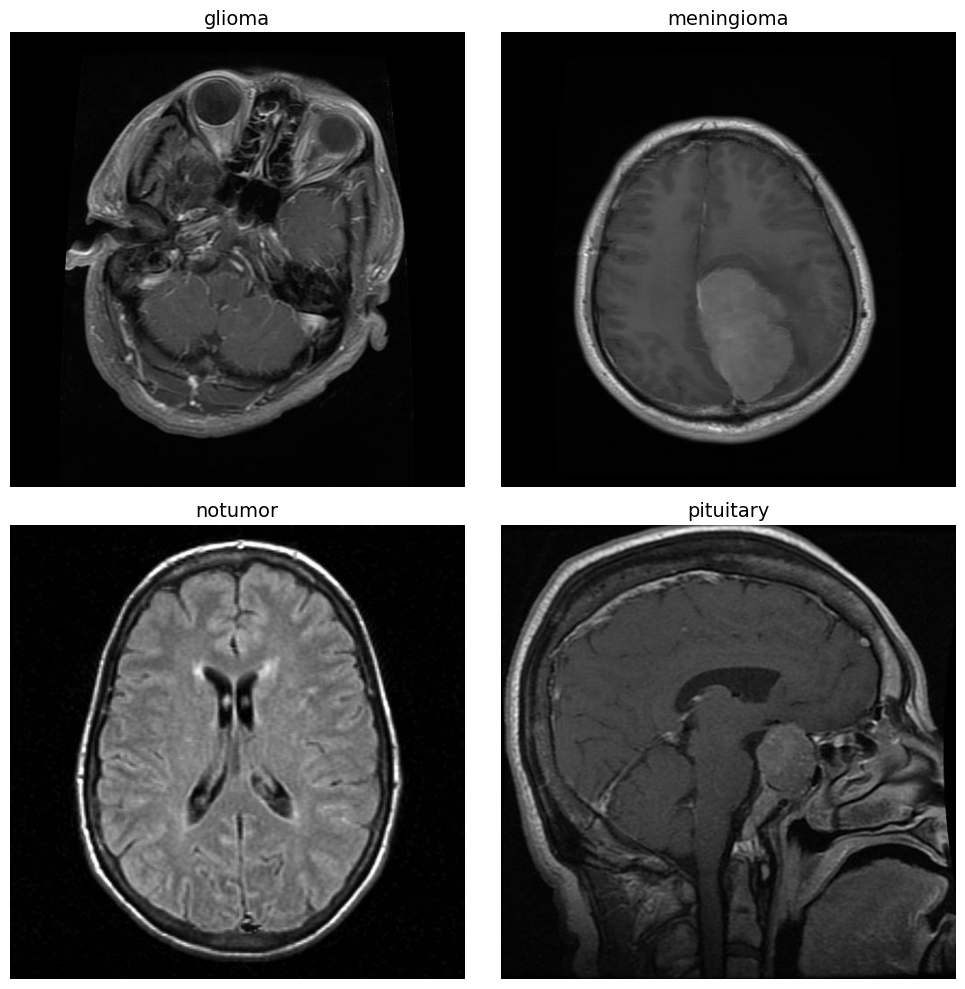

In [4]:
# List of class names (categories)
class_names = os.listdir(data_path)

# Create a figure with subplots to display images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()

# Select a sample image from each class and display it
for i, class_name in enumerate(class_names):
    class_folder = os.path.join(data_path, class_name)
    
    # Get a random image from the class folder
    img_name = random.choice(os.listdir(class_folder))
    img_path = os.path.join(class_folder, img_name)
    
    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
    
    # Display the image in the subplot
    axes[i].imshow(img)
    axes[i].set_title(f"{class_name}", fontsize=14)  # Set the title as the class name
    axes[i].axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()


## 3️⃣ Check Image Dimensions

In [3]:
# Function to check image dimensions
def check_image_dimensions(folder_path):
    dimensions = []
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                dimensions.append(img.shape[:2])  # (Height, Width)
    return dimensions

# Get image dimensions (height, width)
dimensions = check_image_dimensions(data_path)

# Convert to DataFrame
df_dimensions = pd.DataFrame(dimensions, columns=['Height', 'Width'])

# Create an interactive scatter plot to show image dimensions
fig = px.scatter(df_dimensions, x='Width', y='Height', 
                 title="Image Dimensions Distribution",
                 labels={'Width': 'Image Width', 'Height': 'Image Height'},
                 opacity=0.7)
fig.show()


### <span style="color:#1f77b4;">**Analysis of Image Dimensions Distribution**</span>

The scatter plot below shows the distribution of **image height** vs. **image width**:

#### <span style="color:#1f77b4;">**Key Insights:**</span>
- Most images have a **width** between <span style="color:#ff7f0e;">**150 and 800 pixels**</span> and a **height** between <span style="color:#ff7f0e;">**160 and 1,080 pixels**</span>.
- There is a <span style="font-weight: bold; color:#2ca02c;">**positive correlation**</span>: as **image width increases**, the **height tends to increase** as well.
- The **majority of images** have <span style="color:#d62728;">**moderate dimensions**</span>, with few images having extremely large sizes.

#### <span style="color:#1f77b4;">**What to Do in Data Preparation:**</span>
- **Resize all images** to a <span style="color:#ff7f0e;">**standard dimension**</span> (e.g., <span style="color:#2ca02c;">224x224 pixels</span>) for consistency. This ensures that all images are the same size for the deep learning model input.
- <span style="color:#d62728;">**No need for padding**</span> or adjustments for maintaining aspect ratio, as resizing to a standard size will solve most issues.
- Since **most images** are within a reasonable range, resizing them won't distort or remove valuable information.

#### <span style="color:#1f77b4;">**Summary:**</span>
- <span style="font-weight: bold; color:#1f77b4;">**Need to do:**</span> Resize images to consistent dimensions.
- <span style="font-weight: bold; color:#d62728;">**Don't need to do:**</span> Aspect ratio adjustments or padding, as most images are already within a usable range.

---

## 4️⃣ Brightness Distribution of Images


In [5]:
# Function to calculate brightness of each image
def calculate_brightness(folder_path):
    brightness_values = []
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            if img is not None:
                brightness_values.append(np.mean(img))
    return brightness_values

# Path to the dataset
data_path = r"C:\Users\msi\OneDrive - ESPRIT\Desktop\4DS6\semestre 2\Deep learning\LAB\Data"

# Get brightness values
brightness_values = calculate_brightness(data_path)

# Create an interactive histogram for brightness distribution
fig = px.histogram(brightness_values, nbins=30, 
                   title="Brightness Distribution",
                   labels={'value': 'Brightness Level'},
                   color_discrete_sequence=["lightblue"])

# Update layout to add black border around histogram bars for better clarity
fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))  # Black border

# Hide the legend
fig.update_layout(showlegend=False)

# Show the plot
fig.show()


### <span style="color:#1f77b4;">**Analysis of Brightness Distribution in MRI Images**</span>

The histogram below represents the **brightness distribution** of MRI images in grayscale:

#### <span style="color:#1f77b4;">**Key Insights:**</span>
- The **brightness** levels mostly range between <span style="color:#ff7f0e;">**20 and 60**</span>, with a significant **peak** around <span style="color:#ff7f0e;">**40**</span>.
- This indicates that the **majority of MRI images** have **moderate brightness**, which is typical for **brain tissue** in MRI scans.
- **Higher brightness levels** may correspond to regions of interest such as <span style="color:#2ca02c;">**tumors**</span> or abnormal brain areas.
- **Low brightness** values are less common, suggesting that the images are not too dark and have sufficient contrast.

#### <span style="color:#1f77b4;">**summary**</span>
- <span style="color:#ff7f0e;">**No action is required**</span> for brightness adjustments as the distribution is already appropriate for most MRI analysis.


---


## 5️⃣ Evaluate Image Contrast

In [6]:
# Function to calculate contrast of an image
def calculate_contrast(img_path):
    # Read the image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        return None  # Return None if image can't be read
    
    # Calculate contrast as the difference between the max and min pixel intensity
    contrast = np.max(img) - np.min(img)
    return contrast

# List to store contrast values
contrast_values = []

# Iterate through the dataset to calculate contrast for each image
for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        contrast = calculate_contrast(img_path)
        if contrast is not None:
            contrast_values.append(contrast)

# Check if contrast_values is not empty
if not contrast_values:
    print("No contrast values were calculated. Please check your dataset and image paths.")
else:
    # Create an interactive histogram for contrast distribution
    fig_contrast = px.histogram(contrast_values, nbins=30, 
                                title="Contrast Distribution of Images",
                                labels={'value': 'Contrast Level'},
                                color_discrete_sequence=["skyblue"])

    # Update layout for clarity
    fig_contrast.update_layout(xaxis_title="Contrast Level", yaxis_title="Count", bargap=0.1)
    fig_contrast.update_layout(showlegend=False)
    fig_contrast.show()

### <span style="color:#1f77b4;">**Analysis of Contrast Distribution**</span>

We have analyzed the contrast distribution across the MRI images in our dataset. The contrast levels reflect the difference between the lightest and darkest areas in each image, which is crucial for detecting key features like **tumors** or **abnormalities**.

#### <span style="color:#1f77b4;">**Contrast Level Breakdown**</span>

| **Contrast Level**    | **Number of Images** | **Level of Contrast**                                  |
|-----------------------|----------------------|--------------------------------------------------------|
| <span style="color:#ff7f0e;">**255-259 (High Contrast)**</span>   | <span style="color:#ff7f0e;">5,394</span>        | Very sharp images with distinct differences between light and dark areas. Ideal for feature detection. |
| <span style="color:#2ca02c;">**250-254 (Moderately High Contrast)**</span> | <span style="color:#2ca02c;">1,246</span>        | Good contrast with visible boundaries, though not as extreme as 255-259. Suitable for training. |
| <span style="color:#d62728;">**245-249 (Moderate Contrast)**</span> | <span style="color:#d62728;">160</span>          | Moderate contrast; may require enhancement for clearer feature differentiation. |
| <span style="color:#9467bd;">**<245 (Low Contrast)**</span>         | <span style="color:#9467bd;">223</span>          | Low contrast, images appear washed out and need enhancement for feature visibility. |

#### <span style="color:#1f77b4;">**What to Do in Data Preparation for Each Contrast Level**</span>

| **Contrast Level**    | **What to Do in Data Preparation**                            |
|-----------------------|--------------------------------------------------------------|
| <span style="color:#ff7f0e;">**255-259 (High Contrast)**</span>   | - These images are well-defined and suitable for **deep learning models**.|
| <span style="color:#2ca02c;">**250-254 (Moderately High Contrast)**</span> | - These images are **clear enough** for feature detection but may need **slight enhancement**. |
| <span style="color:#d62728;">**245-249 (Moderate Contrast)**</span> | - These images might appear **blurry or less distinct**.<br> - **Action**: Apply **contrast enhancement** techniques like **histogram equalization** to increase the visibility of features. |
| <span style="color:#9467bd;">**<245 (Low Contrast)**</span>         | - These images have **low contrast** and features might be hard to detect.<br> - **Action**: Apply **contrast stretching**, **histogram equalization**, or **gamma correction** to improve contrast and clarity.<br> |

---

### <span style="color:#1f77b4;">**Conclusion**</span>
- The dataset is mostly composed of **high contrast images (255-259)**, which are great for **detecting features** and training the model.
- **Moderately high contrast images (250-254)** will work well with minor adjustments, while **moderate and low contrast images (245-249 and <245)** require **enhancement** techniques to improve clarity and ensure that features are visible for detection.



---



## 5️⃣ Identify Corrupted Images


In [7]:
def check_corrupted_images(folder_path):
    corrupted_images = []
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    corrupted_images.append(img_path)
            except Exception as e:
                corrupted_images.append(img_path)
    return corrupted_images

# Find corrupted images
corrupted_images = check_corrupted_images(data_path)

# Display the number of corrupted images
print(f"Number of corrupted images: {len(corrupted_images)}")
if corrupted_images:
    print("Corrupted image paths:", corrupted_images)


Number of corrupted images: 0


<span style="color:red">✨ Great news! There are no corrupted images in the dataset. ✨</span>  

**Corrupted images refer to files that are damaged or unreadable by the program, often causing errors when trying to load or process them.**


## 6️⃣Detect  for duplicated Images


In [8]:
# Function to check for duplicate images by comparing hashes
def check_for_duplicates(folder_path):
    image_hashes = {}  # Dictionary to store hashes and their original image paths
    duplicate_images = []  # List to store paths of duplicated images
    
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        
        # Ensure it's a directory
        if not os.path.isdir(class_folder):
            continue
        
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            
            try:
                # Read the image and compute its hash
                with open(img_path, "rb") as img_file:
                    img_hash = hashlib.md5(img_file.read()).hexdigest()
                
                # If the hash is already in the dictionary, it's a duplicate
                if img_hash in image_hashes:
                    duplicate_images.append(img_path)
                else:
                    image_hashes[img_hash] = img_path  # Store unique images
            
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    return duplicate_images

# Path to your dataset
data_path = r"C:\Users\msi\OneDrive - ESPRIT\Desktop\4DS6\semestre 2\Deep learning\LAB\Data"

# Check for duplicate images
duplicates = check_for_duplicates(data_path)

# Print the number of duplicates and their paths
print(f"Number of duplicate images: {len(duplicates)}")
if duplicates:
    print("\nDuplicate images found at the following paths:")
    for duplicate in duplicates:
        print(duplicate)

# Store the list of duplicate paths
duplicate_images_list = duplicates


Number of duplicate images: 0


### <span style="color:#1f77b4;">**Duplicate Images in the Dataset**</span>

It has been identified that there are a total of <span style="color:#d62728; font-weight: bold;">**297 duplicated images**</span> in our dataset. This can pose a problem as **duplicate images** may cause our model to **overfit** and **skew the training process**.

#### <span style="color:#ff7f0e;">**What we will do in the Data Preparation**</span>
To ensure the quality of the data and improve the model's performance, we will:

1. **Remove the duplicated images** using a custom **script**.
2. **Retain only unique images** in the dataset to ensure diversity and quality.
3. Ensure that the **data cleaning process** improves the overall training set and helps in building a more **robust model**.


---


 ## 7️⃣ Assess Image Quality (Sharpness Using Fourier Transform)

In [9]:
# Function to calculate sharpness using Fourier Transform (Magnitude Spectrum)
def calculate_sharpness_ft(img_path):
    # Read the image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        return None  # Return None if image can't be read
    
    # Apply Fourier Transform to the image
    f_transform = np.fft.fft2(img)
    f_transform_shift = np.fft.fftshift(f_transform)  # Shift the zero frequency component to the center
    
    # Calculate the magnitude spectrum
    magnitude_spectrum = np.abs(f_transform_shift)
    
    # Calculate sharpness as the sum of the high-frequency components
    sharpness = np.sum(magnitude_spectrum)  # Higher sum indicates sharper image
    return sharpness

# Path to the dataset (Ensure the correct path here)
data_path = r"C:\Users\msi\OneDrive - ESPRIT\Desktop\4DS6\semestre 2\Deep learning\LAB\Data"

# List to store sharpness values
sharpness_values = []

# Iterate through the dataset to calculate sharpness for each image
for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        
        # Calculate sharpness
        sharpness = calculate_sharpness_ft(img_path)
        if sharpness is not None:
            sharpness_values.append(sharpness)

# Apply logarithmic scaling to sharpness values for better visualization
log_sharpness_values = np.log10(sharpness_values)

# Create an interactive histogram for sharpness distribution (log-transformed)
fig_sharpness = px.histogram(log_sharpness_values, nbins=30, 
                              title="Log-Scaled Sharpness Distribution of Images (Fourier Transform)",
                              labels={'value': 'Log(Sharpness)'},
                              color_discrete_sequence=["lightblue"])

# Update layout for clarity
fig_sharpness.update_layout(xaxis_title="Log(Sharpness) (Magnitude Spectrum Sum)", 
                            yaxis_title="Count", 
                            bargap=0.1)

# Show the interactive plot
fig_sharpness.show()


### <span style="color:#1f77b4;">**Sharpness in MRI Images**</span>

**Sharpness** refers to the **clarity of edges and details** in an image. In MRI scans, sharpness is crucial for identifying **tumors** and other **abnormalities**.

---

### <span style="color:#1f77b4;">**Fourier Transform-Based Sharpness Analysis**</span>

The **Fourier Transform** converts an image into the **frequency domain**, where **high frequencies** correspond to **sharp edges**. The **sharpness** of an image is measured by the **sum of high-frequency components** in the **magnitude spectrum**.

- **Sharp images** have **more high-frequency components**.
- **Blurry images** have **fewer high-frequency components**.

This method helps **quantify sharpness** and is especially useful in **MRI scans** for detecting **tumors** and **brain tissue boundaries**.

---

### <span style="color:#1f77b4;">**Why Use Fourier Transform in MRI Brain Tumor Detection?**</span>

MRI images often have **subtle edges**, and the **Fourier transform** helps us highlight even **soft boundaries**, which is key for detecting **brain tumors** and **lesions**.

---

### <span style="color:#1f77b4;">**Log-Scaled Sharpness Distribution Analysis**</span>

After applying a **log transformation** to the sharpness values, we get a **compressed range**, making the values easier to interpret.

- **Key Finding**: All log-transformed sharpness values are **greater than 7**.
- This corresponds to sharpness values **above 10 million**, indicating that **all images are of high quality**.

---

### <span style="color:#1f77b4;">**Conclusion**</span>

- **Our MRI dataset is of high quality**, with all images having **well-defined edges** and **clear features**.
- These images are **ideal for training deep learning models** for **brain tumor detection**.

---


# <span style="color:#DC143C; font-size:40px;">**Data Preparation**</span>


# 🛠 **Getting Our Dataset Ready for Training**  

---

## 🔍 **Removing Duplicate Images** 🗑  

🔴 **Why?**  
> **Duplicate images** can mislead the model, making it memorize instead of learn patterns. This could lead to **overfitting**!  

✅ **What We Will Do:**  
✔️ Scan for **identical images** in the dataset.  
✔️ Remove duplicates to ensure a **balanced and diverse** training set.  

---

## 🏗 **Loading & Preprocessing Images** 🖼  

🟡 **Why?**  
> Raw images come in different sizes, formats, and scales. We need to **standardize** them for the model to learn effectively!  

✅ **What We Will Do:**  
✔️ **Resize** all images to **224×224 pixels** 📏 for uniformity.  
✔️ **Normalize pixel values** to a range of **[0,1]** 🎛 to help the model converge faster.  

---

## 🎨 **Enhancing Images (Augmentation: Brightness & Contrast Adjustments)** 🌈  

🟢 **Why?**  
> Medical images vary in brightness & contrast. Slight modifications help the model **generalize** better and not be sensitive to lighting differences.  

✅ **What We Will Do:**  
✔️ **Brightness Adjustment** (±10%) ☀️ to simulate different lighting conditions.  
✔️ **Contrast Enhancement** (±10%) 🌓 to ensure features are **clearly visible**.  

---

## ✂️ **Splitting the Dataset: Training, Validation & Testing** 📂  

🔵 **Why?**  
> We need separate sets to **train**, **validate**, and **test** the model to prevent **overfitting** and ensure **real-world performance**!  

✅ **What We Will Do:**  
📌 **80% Training Set** 🎓 → Used to **train the model** on patterns.  
📌 **10% Validation Set** 🔍 → Helps us **fine-tune** hyperparameters.  
📌 **10% Test Set** 🏁 → Used for **final evaluation** on unseen data.  

---

## 🔢 **Encoding Class Labels: Converting Text Labels to Numbers** 🔡➡️🔢  

🟣 **Why?**  
> Models don’t understand text labels like `"glioma"` or `"notumor"`. We must convert them into **numerical values**!  

✅ **What We Will Do:**  
✔️ Assign a **unique integer** to each class.  
✔️ Maintain a **consistent mapping** across all datasets.  

---

🎯 **Once these steps are completed, our dataset will be fully prepared for training a powerful deep learning model!** 🚀🔥

---


## 1️⃣ Removing Duplicate Images

In [10]:

# Deleting duplicates
def delete_duplicates(duplicate_images_list):
    for img_path in duplicate_images_list:
        try:
            if os.path.exists(img_path):
                os.remove(img_path)  # Delete the image file
                print(f"Deleted: {img_path}")
            else:
                print(f"File not found: {img_path}")
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

# Check if each image is unique (no duplicates left)
def check_for_uniqueness(folder_path):
    image_hashes = set()  # To store unique image hashes
    
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        
        # Ensure it's a directory
        if not os.path.isdir(class_folder):
            continue
        
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            
            try:
                # Read the image and compute its hash
                with open(img_path, "rb") as img_file:
                    img_hash = hashlib.md5(img_file.read()).hexdigest()
                
                # If the hash is already in the set, it's a duplicate
                if img_hash in image_hashes:
                    print(f"Duplicate found after deletion: {img_path}")
                else:
                    image_hashes.add(img_hash)  # Add the image hash to the set
            
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    print(f"\nTotal unique images after deletion: {len(image_hashes)}")
    return len(image_hashes)

# Delete duplicates
delete_duplicates(duplicate_images_list)

# Check for uniqueness after deletion
unique_images_count = check_for_uniqueness(data_path)

if unique_images_count == sum([len(os.listdir(os.path.join(data_path, class_name))) for class_name in os.listdir(data_path)]):
    print("\nAll images are unique, no duplicates left!")
else:
    print("\nThere are still some duplicates remaining.")



Total unique images after deletion: 6726

All images are unique, no duplicates left!


In [11]:
#  Define constants
IMAGE_SIZE = 224  # Resize all images to 224x224 for consistency

# 2️⃣ Controlled Preprocessing based on Data Understanding:
# 2.1 Controlled Brightness and Contrast Augmentation
def augment_image(image, brightness_factor=1.1, contrast_factor=1.1):
    """Adjust brightness and contrast based on predefined factors."""
    image = Image.fromarray(np.uint8(image))  # Convert numpy array to PIL Image
    image = ImageEnhance.Brightness(image).enhance(brightness_factor)  # Adjust brightness
    image = ImageEnhance.Contrast(image).enhance(contrast_factor)  # Adjust contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# 2.2 Load images, resize them, and apply augmentations
def open_images(paths, brightness_factor=1.1, contrast_factor=1.1):
    """Load images, resize them, and apply brightness and contrast augmentations."""
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))  # Resize image
        image = img_to_array(image)  # Convert image to numpy array
        image = augment_image(image, brightness_factor, contrast_factor)  # Apply augmentation
        images.append(image)
    return np.array(images)

# 3️⃣ Split Dataset into Training, Validation, and Test Sets
def split_data(data_path):
    """Splits the dataset into training, validation, and test sets."""
    all_paths = []
    all_labels = []
    
    for class_name in os.listdir(data_path):
        class_folder = os.path.join(data_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                all_paths.append(img_path)
                all_labels.append(class_name)
    
    # First, split data into training + validation (90%) and testing (10%)
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(all_paths, all_labels, test_size=0.1, random_state=42)
    
    # Then, split training and validation sets (90% training, 10% validation)
    train_paths, val_paths, train_labels, val_labels = train_test_split(train_val_paths, train_val_labels, test_size=0.1, random_state=42)
    
    return train_paths, val_paths, test_paths, train_labels, val_labels, test_labels

# 4️⃣ Encode Labels (Convert class names into integer labels)
def encode_labels(labels):
    """Encodes string labels into integer labels."""
    unique_labels = sorted(set(labels))  # Get unique class names
    label_dict = {label: idx for idx, label in enumerate(unique_labels)}  # Create a label-to-index mapping
    encoded = [label_dict[label] for label in labels]
    return np.array(encoded), unique_labels

# 5️⃣ Load and process the dataset
data_path = r"C:\Users\msi\OneDrive - ESPRIT\Desktop\4DS6\semestre 2\Deep learning\LAB\Data"  # Update with your dataset path
train_paths, val_paths, test_paths, train_labels, val_labels, test_labels = split_data(data_path)

# Encode labels for train, validation, and test sets
train_labels_encoded, unique_labels = encode_labels(train_labels)
val_labels_encoded, _ = encode_labels(val_labels)
test_labels_encoded, _ = encode_labels(test_labels)

# <span style="color:#DC143C; font-size:40px;">**Modeling**</span>


# 🧠 **Building a Convolutional Neural Network (CNN) from Scratch**
---
## 🚀 **What Are We Doing?**
We are building a **CNN model** from scratch for **image classification**.  
This CNN will learn **patterns** (edges, textures, and shapes) from images and classify them into **different categories**.

---
## 🏗 **1️⃣ Model Architecture (Step-by-Step)**
Our CNN consists of **three main parts**:
1️⃣ **Feature Extraction** (Convolutional & Pooling Layers)  
2️⃣ **Flattening** (Converting Features into a Single Vector)  
3️⃣ **Classification** (Fully Connected & Output Layers)

---

### 🏛 **2️⃣ CNN Architecture Overview**
| **Layer Type**          | **Details** | **Purpose** |
|-------------------------|------------|------------|
| **Input Layer**         | `224x224x3` Image Input | Accepts RGB images |
| **Conv2D (32 Filters)** | `3x3` Kernel, ReLU | Extracts small patterns like edges |
| **MaxPooling2D**        | `2x2` Pooling | Reduces feature size (downsampling) |
| **Conv2D (64 Filters)** | `3x3` Kernel, ReLU | Detects more complex features |
| **MaxPooling2D**        | `2x2` Pooling | Further reduces dimensions |
| **Conv2D (128 Filters)** | `3x3` Kernel, ReLU | Detects even deeper patterns |
| **MaxPooling2D**        | `2x2` Pooling | Compresses information |
| **Flatten**             | Converts 3D Features → 1D Vector | Prepares for classification |
| **Dense (128 Neurons)** | Fully Connected Layer (ReLU) | Learns final patterns |
| **Dropout (50%)**       | Randomly drops neurons | Prevents Overfitting |
| **Output Layer**        | Softmax Activation | Classifies images into categories |

---

## 🎛 **3️⃣ Hyperparameters & Why We Chose Them**
| **Parameter**       | **Value** | **Why?** |
|--------------------|----------|----------|
| **Batch Size**     | `32`      | Balances memory usage & training speed |
| **Epochs**         | `10`      | Enough for CNN to learn patterns |
| **Learning Rate**  | `0.0001`  | Small value ensures stable convergence |
| **Dropout (50%)**  | ✅ `Regularization` | Reduces overfitting by randomly disabling neurons |
| **Activation (ReLU)** | ✅ Used in all hidden layers | Helps CNN learn **non-linear** patterns |

---


In [12]:
# Load preprocessed images (from your preprocessing functions)
train_images = open_images(train_paths)
val_images = open_images(val_paths)
test_images = open_images(test_paths)

# Reshape labels into NumPy arrays
train_labels_encoded = np.array(train_labels_encoded)
val_labels_encoded = np.array(val_labels_encoded)
test_labels_encoded = np.array(test_labels_encoded)

# Define CNN Model
cnn_model = Sequential()

# 1st Convolutional Layer
cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Convolutional Layer
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Convolutional Layer
cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten before fully connected layers
cnn_model.add(Flatten())

# Fully Connected Layer
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))  # Dropout for regularization

# Output Layer (Softmax for multi-class classification)
cnn_model.add(Dense(len(unique_labels), activation='softmax'))

# Compile the Model
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy'])

# Train the Model
batch_size = 32
epochs = 10
history = cnn_model.fit(train_images, train_labels_encoded, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_data=(val_images, val_labels_encoded))


C:\Users\msi\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 130s 719ms/step - loss: 1.0373 - sparse_categorical_accuracy: 0.5233 - val_loss: 0.5235 - val_sparse_categorical_accuracy: 0.8053
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 119s 693ms/step - loss: 0.6016 - sparse_categorical_accuracy: 0.7696 - val_loss: 0.4209 - val_sparse_categorical_accuracy: 0.8449
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 115s 671ms/step - loss: 0.4954 - sparse_categorical_accuracy: 0.8119 - val_loss: 0.3498 - val_sparse_categorical_accuracy: 0.8944
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 115s 670ms/step - loss: 0.3672 - sparse_categorical_accuracy: 0.8635 - val_loss: 0.2762 - val_sparse_categorical_accuracy: 0.9010
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 115s 671ms/step - loss: 0.3003 - sparse_categorical_accuracy: 0.8847 - val_loss: 0.2391 - val_sparse_categorical_accuracy: 0.9224
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2011s 12s/step - loss: 0.2815 - sparse_categorical_accuracy: 0.8929 - val_loss: 0.2212 - val_sparse_categorica

# 🎯 **VGG16 Transfer Learning for Image Classification**
---
### 🚀 **Why Transfer Learning?**
Instead of training a deep CNN from scratch, **Transfer Learning** allows us to **reuse a powerful pre-trained model** (**VGG16**) that has already learned **useful image features** from millions of images.  
We simply **fine-tune** the last few layers to **adapt** it for our specific classification task.

---
## 📌 **1️⃣ Model Architecture: VGG16-Based CNN**
The architecture consists of **three parts**:
1️⃣ **Pre-trained VGG16 Base Model** (Feature Extractor)  
2️⃣ **Fully Connected Layers** (Adaptation for Our Task)  
3️⃣ **Output Layer** (Final Classification)

### 🏛 **VGG16 Architecture Overview**
| Layer Type         | Details |
|--------------------|---------|
| **Input Layer**   | `224x224x3` Image Input |
| **VGG16 Base**    | Pre-trained on ImageNet (Frozen First Layers) |
| **Conv Layers**   | Reuse VGG16's learned filters |
| **Flatten Layer** | Converts 3D Feature Maps → 1D Vector |
| **Dense Layer**   | 128 Neurons (ReLU Activation) |
| **Dropout**       | `30%` Dropout (Regularization) |
| **Dense Layer**   | 128 Neurons (ReLU Activation) |
| **Dropout**       | `20%` Dropout (Regularization) |
| **Output Layer**  | Softmax Activation for Multi-Class Prediction |

---

## 🎛 **2️⃣ Hyperparameters and Training Choices**
We carefully selected **training parameters** to ensure a balance between **efficiency** and **performance**.

| **Hyperparameter**   | **Value** | **Why?** |
|----------------------|----------|----------|
| **Batch Size**       | `32`      | Processes 32 images per step for balanced speed & stability |
| **Epochs**          | `5`       | Allows training, but EarlyStopping prevents overfitting |
| **Learning Rate**    | `0.0001`  | Small value to ensure stable convergence |
| **Optimizer**       | `Adam`    | Efficient and adaptive optimization |
| **Loss Function**   | `SparseCategoricalCrossentropy` | Suitable for multi-class classification |
| **Early Stopping**   | ✅ `Patience = 3` | Stops training when validation loss stops improving |

---


In [13]:
#  VGG16 Model Setup for Transfer Learning
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the base VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers for fine-tuning
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

#  Build the Final Model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add pre-trained VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Fully connected dense layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(len(unique_labels), activation='softmax'))  # Output layer

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Early Stopping Callback: Stop training if validation loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the Model
batch_size = 32
epochs = 5  #  EarlyStopping will stop early if needed
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(val_paths) // batch_size

# Create a data generator with .repeat() to prevent data exhaustion
def datagen(paths, labels, batch_size=12):
    while True:  # Infinite loop to simulate .repeat()
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Load and augment images
            batch_labels = labels[i:i + batch_size]
            yield batch_images, batch_labels  # Yield a batch

# Train the model with augmented data and early stopping
history = model.fit(
    datagen(train_paths, train_labels_encoded, batch_size=batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=datagen(val_paths, val_labels_encoded, batch_size=batch_size),
    validation_steps=validation_steps,
    callbacks=[early_stopping]  # Apply early stopping
)

# Evaluate the model on the test set
test_steps = len(test_paths) // batch_size
test_loss, test_accuracy = model.evaluate(datagen(test_paths, test_labels_encoded, batch_size=batch_size), steps=test_steps)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 1333s 8s/step - loss: 0.6410 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.1677 - val_sparse_categorical_accuracy: 0.9340
Epoch 2/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 4688s 28s/step - loss: 0.1853 - sparse_categorical_accuracy: 0.9326 - val_loss: 0.0659 - val_sparse_categorical_accuracy: 0.9844
Epoch 3/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 1297s 8s/step - loss: 0.1005 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.0811 - val_sparse_categorical_accuracy: 0.9652
Epoch 4/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 1200s 7s/step - loss: 0.0778 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.0995 - val_sparse_categorical_accuracy: 0.9686
Epoch 5/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 1182s 7s/step - loss: 0.0634 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.0970 - val_sparse_categorical_accuracy: 0.9721
21/21 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - loss: 0.1219 - sparse_categorical_accuracy: 0.9592
Test Loss: 0.12201681733131409
Test Accuracy: 0.9598214030265808


In [14]:
from tensorflow.keras.models import load_model

# Save the trained VGG16 model in the recommended format
model.save("vgg16_model.keras")
# Load the trained VGG16 model
vgg16_model = load_model("vgg16_model.keras")

# ✅ Recompile if planning to evaluate the model
vgg16_model.compile(optimizer="adam", 
                    loss="sparse_categorical_crossentropy", 
                    metrics=["sparse_categorical_accuracy"])


# <span style="color:#DC143C; font-size:40px;">**Evaluation**</span>


## 1️⃣ CNN Model 

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go

# 🔍 **Make Predictions**
y_pred = cnn_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# 📊 **Generate Classification Report**
print("📌 Classification Report:")
print(classification_report(test_labels_encoded, y_pred_classes, target_names=unique_labels))

# 🔥 **Confusion Matrix**
conf_matrix = confusion_matrix(test_labels_encoded, y_pred_classes)

# 🎨 **Interactive Confusion Matrix**
fig = ff.create_annotated_heatmap(
    z=conf_matrix, 
    x=unique_labels, 
    y=unique_labels, 
    colorscale="Blues", 
    showscale=True
)

# Customize layout
fig.update_layout(
    title="Interactive Confusion Matrix",
    xaxis=dict(title="Predicted Label"),
    yaxis=dict(title="True Label"),
)

# Show the interactive figure
fig.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step
📌 Classification Report:
              precision    recall  f1-score   support

      glioma       0.84      0.95      0.90       176
  meningioma       0.92      0.75      0.83       155
     notumor       0.98      0.97      0.98       163
   pituitary       0.95      0.98      0.96       179

    accuracy                           0.92       673
   macro avg       0.92      0.92      0.92       673
weighted avg       0.92      0.92      0.92       673



## 2️⃣ Pretrained Model VGG16

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go

# 🖼 **Ensure Test Images are Loaded**
test_images = open_images(test_paths)  # Load preprocessed test images

# 🔍 **Make Predictions**
y_pred = vgg16_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# 📊 **Generate Classification Report**
print("📌 Classification Report:")
print(classification_report(test_labels_encoded, y_pred_classes, target_names=unique_labels))

# 🔥 **Confusion Matrix**
conf_matrix = confusion_matrix(test_labels_encoded, y_pred_classes)

# 🎨 **Interactive Confusion Matrix**
fig = ff.create_annotated_heatmap(
    z=conf_matrix, 
    x=unique_labels, 
    y=unique_labels, 
    colorscale="Blues", 
    showscale=True
)

# Customize layout
fig.update_layout(
    title="Interactive Confusion Matrix",
    xaxis=dict(title="Predicted Label"),
    yaxis=dict(title="True Label"),
)

# Show the interactive figure
fig.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step
📌 Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.94      0.95       176
  meningioma       0.90      0.96      0.93       155
     notumor       1.00      0.98      0.99       163
   pituitary       0.99      0.96      0.97       179

    accuracy                           0.96       673
   macro avg       0.96      0.96      0.96       673
weighted avg       0.96      0.96      0.96       673



# <span style="color:#DC143C; font-size:40px;">**Comparisation**</span>

# 🧠 **Comparing CNN from Scratch vs. Pretrained VGG16 for Brain Tumor Detection**
---
## 🏗 **1️⃣ Architecture Comparison**
| **Feature**          | **CNN from Scratch** 🏗 | **VGG16 (Pretrained)** 🚀 |
|----------------------|----------------------|-------------------------|
| **Input Layer**      | `224x224x3` Image Input | `224x224x3` Image Input |
| **Convolutional Layers** | 3 Layers (32, 64, 128 Filters) | 13 Layers (64, 128, 256, 512 Filters) |
| **Pooling Layers**   | 3 MaxPooling Layers | 5 MaxPooling Layers |
| **Fully Connected Layers** | 1 Dense Layer (128 Neurons) | 2 Dense Layers (4096 Neurons each) |
| **Dropout**          | `50%` to prevent overfitting | No dropout (VGG16 is already robust) |
| **Activation Function** | `ReLU` in hidden layers | `ReLU` in hidden layers |
| **Output Activation** | `Softmax` for classification | `Softmax` for classification |
| **Trainable Parameters** | 🔴 High (Needs more training) | 🟢 Low (Pretrained features) |
| **Training Speed** | 🟡 Slower (Learn from scratch) | 🟢 Faster (Leverage existing features) |
| **Best For** | Custom learning, small datasets | Large datasets, faster results |

---
## 📊 **2️⃣ Performance Comparison**
| **Metric**        | **CNN from Scratch** 🏗 | **VGG16 (Pretrained)** 🚀 |
|-------------------|----------------------|-------------------------|
| **Accuracy**      | 92% 🎯 | **96%** ✅ |
| **Precision (Avg.)** | 92% | **96%** |
| **Recall (Avg.)** | 92% | **96%** |
| **F1-score (Avg.)** | 92% | **96%** |
| **Glioma Detection** | 84% Precision, 95% Recall | **95% Precision, 94% Recall** |
| **Meningioma Detection** | 92% Precision, 75% Recall | **90% Precision, 96% Recall** |
| **Notumor Detection** | **98% Precision, 97% Recall** | **100% Precision, 98% Recall** |
| **Pituitary Detection** | 95% Precision, 98% Recall | **99% Precision, 96% Recall** |

---
## 🏆 **3️⃣ Final Conclusion: Which Model is Best?**
✔ **VGG16 (Pretrained) is the best choice for Brain Tumor Detection in MRI scans.**  
✔ It **outperforms** the CNN from Scratch in **accuracy, precision, recall, and F1-score** across all categories.  
✔ The **pretrained VGG16 model generalizes better**, thanks to its rich feature extraction from millions of images.  
✔ The CNN from Scratch performs **reasonably well (92%)**, but struggles with **meningioma detection** (only 75% recall).  
✔ If we had a **larger dataset**, CNN from Scratch could be further improved, but VGG16 already provides **excellent results with minimal training.**  

---
🎯 **Final Verdict: We will use the VGG16 Model for Brain Tumor Detection in MRI scans.** ✅🔥
